# Shor's Factoring Algorithm

The goal of Shor's factoring algorithm is to find the prime factors of an integer $N$. Shor's algorithm only works on composite (non-prime) numbers that are also not a power of a prime number. For example, it won't work on $9$ since $9 = 3^2$. If $N$ is not a power of a prime number, it must be the product of two coprime numbers greater than one. (Coprime numbers are numbers whose greatest common denominator is one.)

The Chinese Remainder Theorem states that $1$ mod $N$ has at least four unique square roots; two of them are trivially $1$ and $-1$. The goal of this algorithm is to find a square root $b$ that is not $1$ or $-1$, which will lead us to find the factors of $N$.

The complete algorithm is as follows:
1. Pick a random number $a < N$.
1. Compute gcd$(a,N)$, perhaps using Euclid's algorithm.
1. If gcd$(a,N) \neq 1$, then we have found a factor of $N$, so we are done.
1. Otherwise, we use the quantum period-finding algorithm to find the period $r$ of $f(x) = a^x$ mod $N$.
1. If $r$ is odd or $a^{r/2} \equiv -1$ mod $N$, go back to step 1.
1. Otherwise, gcd$(a^{r/2} + 1, N)$ and gcd$(a^{r/2} - 1, N)$ are the factors of $N$, so we are done.

So, let's dive right into the algorithm. First, we'll import the necessary Python packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import gcd
from ipywidgets import interactive
%matplotlib inline

Next, let's pick an $N$ to factor. Run the cell below and input any $N$ from 6 to 99.

In [2]:
def isPrime(n):
    for i in range(2, int(np.sqrt(N)) + 1):
        if n % i == 0:
            return False
    return True

def isPowerOfPrime(n):
    for i in range(2, int(np.log2(n)) + 1):
        if (n ** (1/i)).is_integer():
            return True
    return False

while True:
    N = int(input())
    if N >= 100:
        print('{} is too large for this computer to handle. Please pick N < 100.'.format(N))
        continue
    elif isPrime(N):
        print('{} is a prime number, so it is not factorable. Please select another N.'.format(N))
    elif isPowerOfPrime(N):
        print('{} is a power of a prime number. Please select another N.'.format(N))
    else:
        break

21


After we've picked an $N$, we must pick an $a < N$ at random. The cell below allows you to scrub through several values of $a$, and view the resulting function $f(x) = a^x$ mod $N$. Additionally, the Fourier transform of the function is shown on the right.

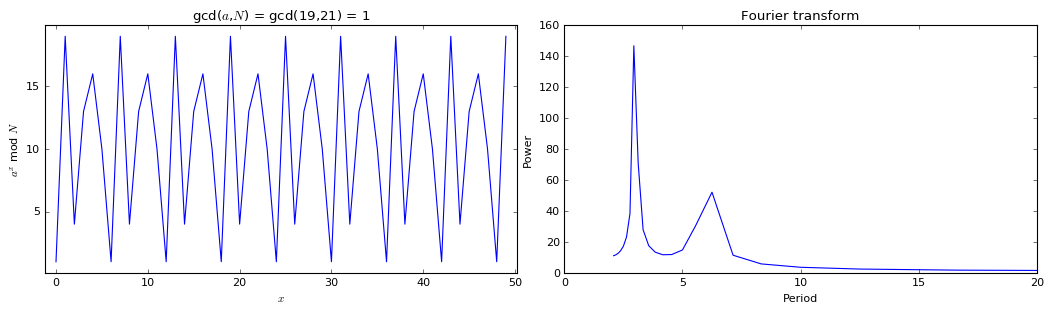

In [3]:
def axmodN(a=19, xmax=50):
    xs = list(range(xmax))
    n = len(xs)
    ys = [pow(a, x, N) for x in xs]
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))
    fig.subplots_adjust(wspace=0.1)
    ax1.plot(xs, ys)
    ax1.margins(0.025, 0.05)
    ax1.set_xlabel('$x$')
    ax1.set_ylabel('$a^x$ mod $N$')
    ax1.set_title('gcd($a$,$N$) = gcd({},{}) = {}'.format(a, N, gcd(a,N)))
    ax2.plot(1/np.fft.fftfreq(n)[1:n//2], np.abs(np.fft.fft(ys))[1:n//2])
    ax2.set_xlim(0,20)
    ax2.set_title('Fourier transform')
    ax2.set_xlabel('Period')
    ax2.set_ylabel('Power')

interactive(axmodN, a=(1,N), xmax=(1, 1000))

Now, let's choose our value of $a$ that we will use for the rest of the algorithm. Additionally, we need to choose a number of qubits $m$, where $N^2 \leq 2^m < 2N^2$. This guaranteees that there are at least $N$ different values of $x$ that produce the same $f(x)$, even if the period is as large as $N/2$. Once we have picked a value for $a$, the quantum period-finding algorithm will attempt to find the period $r$ of $f(x) = a^x$ mod $N$ as described earlier, where $x$ ranges from $0$ to $2^m-1$. Edit the cell below to choose a value for $a$ or uncomment the first line to choose a random $a$.

We need m = 9 qubits, so x will range from 0 to 512.


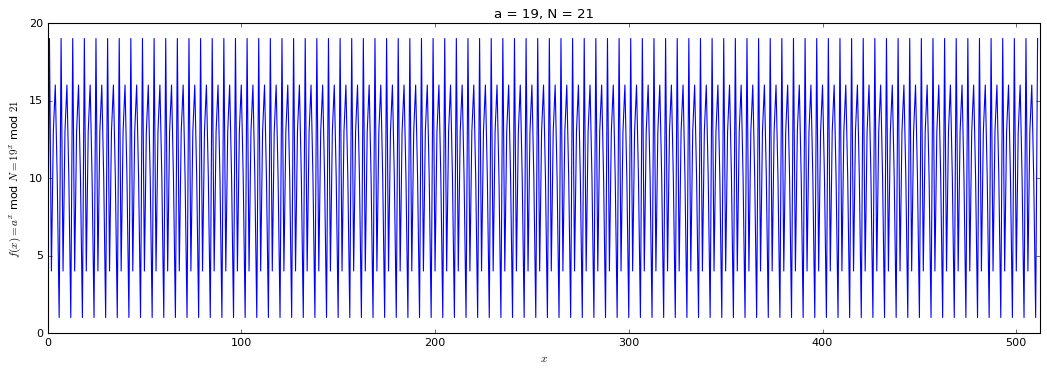

In [10]:
# a = np.random.randint(1,N)
a = 19
m = int(np.ceil(np.log2(N**2)))
M = 2**m
print('We need m = {} qubits, so x will range from 0 to {}.'.format(m, M))
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(range(M), [pow(a, x, N) for x in range(M)])
ax.set_xlim(0, M)
ax.set_xlabel('$x$')
ax.set_ylabel('$f(x) = a^x$ mod $N = {}^x$ mod ${}$'.format(a, N))
_ = ax.set_title('a = {}, N = {}'.format(a, N))

Next, we would like to create a quantum state that is a uniform superposition over all possible $x$ from $0$ to $N-1$, so that we can apply $f(x)$ to all inputs simultaneously. To prepare the state, we apply $QFT_N$ on a state of all 0s to get

\\[
|0\rangle|0\rangle \longrightarrow \frac{1}{\sqrt{N}} \sum\limits_{x=0}^{N-1} |x\rangle|0\rangle
\\]

Knowing that we can construct a unitary matrix $U_f$ that applies the function $f(x)$, we apply it as in Simon's algorithm:

\begin{equation}
\frac{1}{\sqrt{N}} \sum\limits_{x=0}^{N-1} |x\rangle|0\rangle
\longrightarrow
\frac{1}{\sqrt{N}} \sum\limits_{x=0}^{N-1} |x\rangle|f(x)\rangle
\end{equation}

Shown in the cell below are the amplitudes the first few states in our system, then all the states.

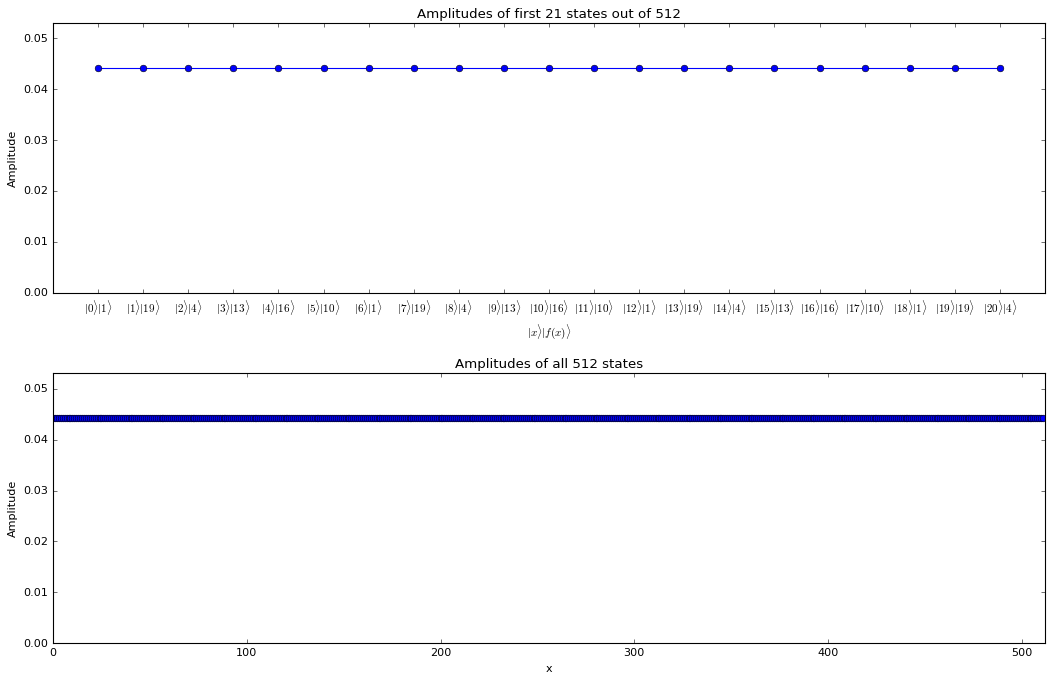

In [25]:
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(16,10))
sample = 21
ax.plot(range(sample), [1/np.sqrt(M)]*sample, 'o-')
ax.set_xticks(range(sample))
ax.set_ylim(0, 1.2/np.sqrt(M))
ax.margins(x=0.05)
ax.set_xticklabels(['$|{}\\rangle|{}\\rangle$'.format(x, pow(a, x, N)) for x in range(sample)])
ax.set_xlabel('$|x\\rangle|f(x)\\rangle$')
ax.set_ylabel('Amplitude')
ax.set_title('Amplitudes of first {} states out of {}'.format(sample, M))

ax2.plot(range(M), [1/np.sqrt(M)]*M, 'o-')
ax2.set_ylim(0, 1.2/np.sqrt(M))
ax2.set_xlim(0, M)
ax2.set_xlabel('x')
ax2.set_ylabel('Amplitude')
ax2.set_title('Amplitudes of all {} states'.format(M))

fig.subplots_adjust(hspace=0.3)

Now, we measure the second register. This collapses the state into:

\begin{equation}
\frac{1}{\sqrt{N}} \sum\limits_{x=0}^{N-1} |x\rangle \otimes |f(x)\rangle
\longrightarrow
\sqrt{\frac{r}{N}} \sum\limits_{i=0}^{N/r-1} |ir+x_0\rangle \otimes |f(x_0)\rangle
\end{equation}

In the cell below, choose a measurement of $f(x)$ from the dropdown menu to see how the state changes.

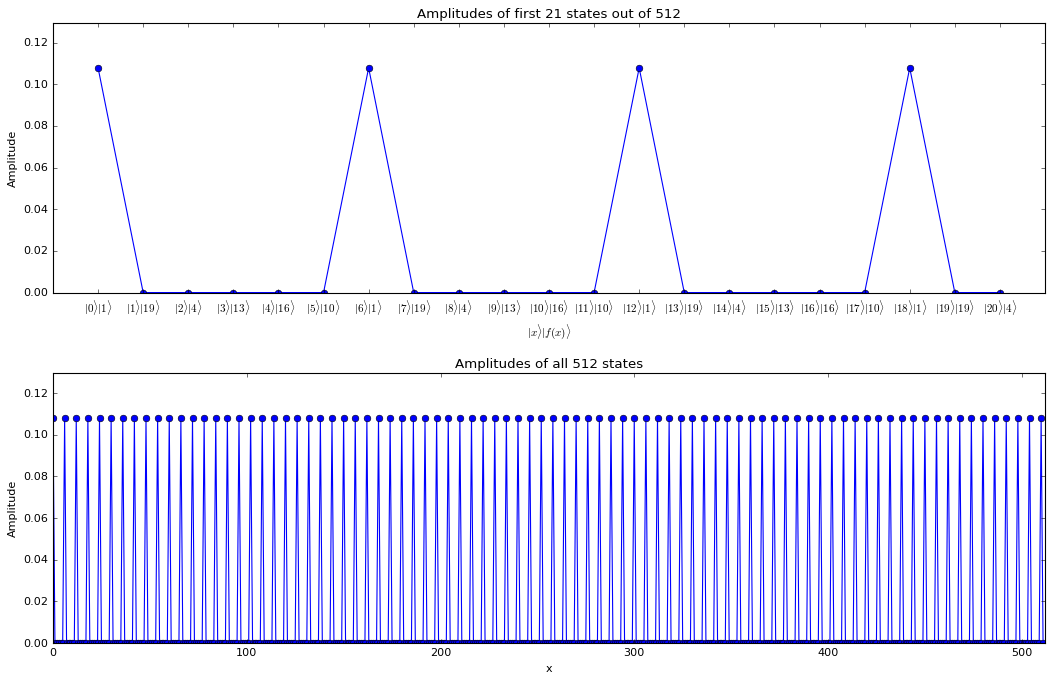

In [29]:
sample = 21

fx = np.array([pow(a, x, N) for x in range(M)])

def measuref(f='1'):
    f = int(f)
    amplitudes = np.zeros(len(fx))
    amplitudes[fx == f] = 1/np.sqrt(np.sum(fx == f))
    fig, (ax, ax2) = plt.subplots(2, 1, figsize=(16,10))
    ax.plot(range(sample), amplitudes[:sample], 'o-')
    ax.set_ylim(0, 1.2*max(amplitudes))
    ax.margins(x=0.05)
    ax.set_xticks(range(sample))
    ax.set_xticklabels(['$|{}\\rangle|{}\\rangle$'.format(x, pow(a, x, N)) for x in range(sample)])
    ax.set_xlabel('$|x\\rangle|f(x)\\rangle$')
    ax.set_ylabel('Amplitude')
    ax.set_title('Amplitudes of first {} states out of {}'.format(sample, M))
    
    ax2.plot(range(M), amplitudes, 'o-')
    ax2.set_ylim(0, 1.2*max(amplitudes))
    ax2.set_xlim(0, M)
    ax2.set_xlabel('x')
    ax2.set_ylabel('Amplitude')
    ax2.set_title('Amplitudes of all {} states'.format(M))
    
    fig.subplots_adjust(hspace=0.3)
    
interactive(measuref, f=[str(i) for i in np.unique(fx)])

Next, we apply the QFT on the first register of our superposition.

\begin{equation}
\sqrt{\frac{r}{N}} \sum\limits_{i=0}^{N/r-1} |ir+x_0\rangle
\longrightarrow
\frac{1}{\sqrt{r}} \sum\limits_{i=0}^{r-1} \left|i\frac{N}{r}\right\rangle \phi_i
\end{equation}

Shown in the cell below is the result of applying the QFT to all qubits in the system.

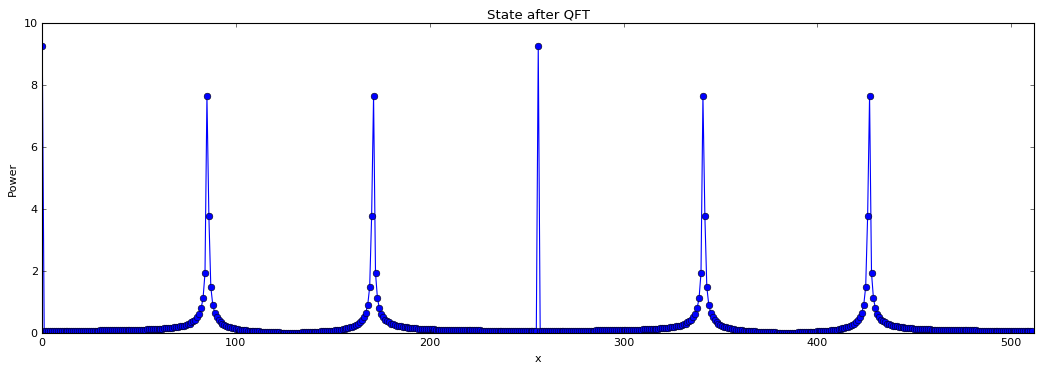

In [32]:
f = 1
amplitudes = np.zeros(M)
amplitudes[fx == f] = 1/np.sqrt(np.sum(fx == f))
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(range(M), np.abs(np.fft.fft(amplitudes)), 'o-')
ax.set_xlim(0, M)
ax.set_ylabel('Power')
ax.set_xlabel('x')
ax.set_title('State after QFT')

Now, we make a measurement to retrieve $k \frac{Q}{r}$ for some integer $k$ (the probabilities of measuring these will be extremely high, as shown in the amplitude plot above). One way to get $r$ would be to repeat this process and measure several $k \frac{Q}{r}$, then compute the GCD of those measurements to get $Q/r$.

In [39]:
r = int(M / 85)
print(r)

6


Finally, for our last step we check if $r$ is even, and that $a^{r/2} \not\equiv -1$ mod $N$.

In [38]:
if r % 2 == 1:
    print('r is odd. Please try again!')
else:
    print('First factor of {} is {}.'.format(N, gcd(int(19**(r/2)) + 1, 21)))
    print('Second factor of {} is {}.'.format(N, gcd(int(19**(r/2)) - 1, 21)))

First factor of 21 is 7.
Second factor of 21 is 3.
